# Exercise 6: Bayesian Model Selection

## Exercise 6.1: Overfitting and model selection

### 6.1.a: Derive the log-likelihood

We consider the polynomial regression model of order $P$:

$$
y_i = \theta_0 + \theta_1 x_i + \theta_2 x_i^2 + \cdots + \theta_P x_i^P + \epsilon_i,
$$

with $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$. Let $X$ be the design matrix and $\mathbf{y} = (y_1, ..., y_N)^T$.

The likelihood is:

$$
p(\mathbf{y}|\boldsymbol{\theta}) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i - X_i\boldsymbol{\theta})^2}{2\sigma^2} \right)
$$

Taking the log:

$$
\log p(\mathbf{y}|\boldsymbol{\theta}) = -\frac{N}{2} \log(2\pi\sigma^2) - \frac{(\mathbf{y} - X\boldsymbol{\theta})^T (\mathbf{y} - X\boldsymbol{\theta})}{2\sigma^2}
$$

### 6.1.b: Expressions for AIC and BIC

* AIC:
$$
\text{AIC} = -2 \log p(\mathbf{y}|\hat{\boldsymbol{\theta}}_{\text{MLE}}) + 2k
$$

* BIC:
$$
\text{BIC} = -2 \log p(\mathbf{y}|\hat{\boldsymbol{\theta}}_{\text{MLE}}) + k \log N
$$

Here $k = P + 1$ is the number of parameters.

### 6.1.c: Analytical log model evidence

Given a Gaussian prior $\boldsymbol{\theta} \sim \mathcal{N}(0, I)$, we compute:

$$
\log p(\mathbf{y}) = -\frac{1}{2\sigma^2} \|\mathbf{y} - X\mu_{\theta|y}\|^2 - \frac{N}{2} \log(2\pi\sigma^2) - \frac{1}{2} \mu_{\theta|y}^T \mu_{\theta|y} + \frac{1}{2} \log |\Sigma_{\theta|y}|
$$

Where:

$$
\Sigma_{\theta|y} = \left( I + \frac{1}{\sigma^2} X^T X \right)^{-1}
\mu_{\theta|y} = \Sigma_{\theta|y} \left( \frac{1}{\sigma^2} X^T \mathbf{y} \right)
$$

### 6.1.d: Simulate and compute metrics

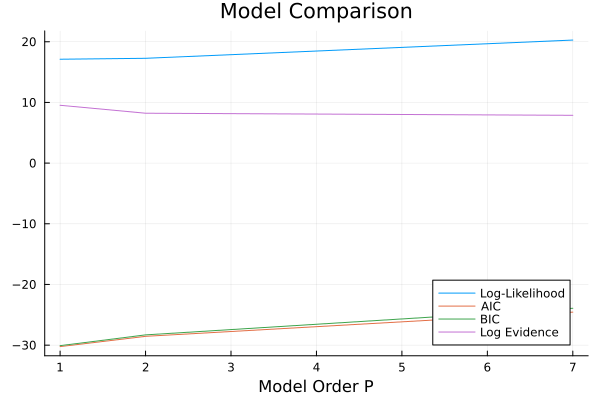

In [1]:
using LinearAlgebra, Distributions, Plots

# True parameters
θ_true = [0.3, -0.1, 0.5]
σ2 = 0.001
σ = sqrt(σ2)

# Generate data
x = collect(-0.5:0.1:0.2)
N = length(x)
X_true = [ones(N) x x.^2]
y = X_true * θ_true .+ randn(N) * σ

Ps = [1, 2, 7]
logL = Float64[]
AIC = Float64[]
BIC = Float64[]
logE = Float64[]

for P in Ps
    X = hcat([x.^p for p in 0:P]...)
    θ_mle = (X'X) \ (X'y)
    residual = y - X*θ_mle
    push!(logL, - (N/2)*log(2π*σ2) - sum(residual.^2)/(2σ2))
    k = P + 1
    push!(AIC, -2*logL[end] + 2*k)
    push!(BIC, -2*logL[end] + k*log(N))
    Σ_post = inv(I + (X'X)/σ2)
    μ_post = Σ_post * (X'y/σ2)
    term1 = - dot(y - X*μ_post, y - X*μ_post)/(2σ2)
    term2 = - (N/2)*log(2π*σ2)
    term3 = - 0.5 * dot(μ_post, μ_post)
    term4 = 0.5 * logdet(Σ_post)[1]
    push!(logE, term1 + term2 + term3 + term4)
end

plot(Ps, [logL AIC BIC logE], label=["Log-Likelihood" "AIC" "BIC" "Log Evidence"], xlabel="Model Order P", legend=:bottomright, title="Model Comparison")

### 6.1.e: Repeat simulation N=100 times and compare criteria

We repeat the above simulation $100$ times with new noise each time. For each simulated dataset, we compute the four criteria for $P=1,2,7$. In practice one can plot the average or scatter of these values. The main observations are:
* Log-likelihood always favors the largest model ($P=7$) on average, because adding parameters cannot decrease the likelihood (overfitting).
* AIC (which uses $2k$ penalty) also tends to favor larger models, though slightly less strongly.
* BIC (penalizing $k\ln N$) more strongly penalizes extra parameters; it often favors the simpler true model ($P=2$) when $N$ is moderately large.
* Log model evidence (Bayesian marginal likelihood) includes an Occam factor penalizing parameter space and typically peaks at the correct model ($P=2$). It penalizes complexity even more than BIC in this small-$N$ regime.

These differences illustrate that simpler criteria like log-likelihood always overfit, AIC partially penalizes, BIC penalizes more, and Bayesian evidence gives a principled balance between fit and complexity.

## Exercise 6.2: Practical application of Bayesian model selection and averaging

In [ ]:
# Start with extracting data
using MAT, Glob, Statistics, Plots

# Set paths to DCM files (update path as needed)
path_model1 = "./DCMs/"

# Load .mat file paths
files_m1 = sort(glob("DCM_model1_*.mat", path_model1))
files_m2 = sort(glob("DCM_model2_*.mat", path_model1))

# Extract negative free energies (approximates log evidence)
F1 = [matread(f)["DCM"]["F"] for f in files_m1]
F2 = [matread(f)["DCM"]["F"] for f in files_m2]

### 6.2.a: Individual Log Bayes Factors

We compute log Bayes factors for each subject:

$$
log BF_n = F_n^{(1)} - F_n^{(2)} 
$$

A positive value favors Model 1, negative favors Model 2.

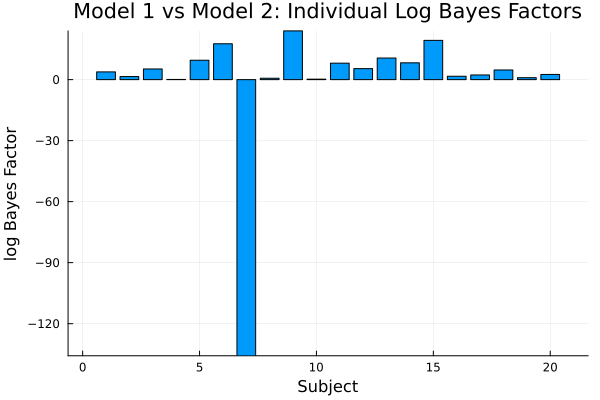

In [3]:
logBF = F1 .- F2

bar(1:length(logBF), logBF, legend=false,
    xlabel="Subject", ylabel="log Bayes Factor",
    title="Model 1 vs Model 2: Individual Log Bayes Factors")